
# PART 2: Crypto Volatility Prediction Engine

----
----

# 0. Importing relevant Libraries

---

In [1]:
# Importing Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import norm, invgamma, uniform, beta, gamma
from tqdm import tqdm

<a id="svcj-overview"></a>

# 1. Stochastic Volatility Model with Co-Jumps (SVCJ) Model

The SVCJ model is an extension of stochastic volatility models, incorporating jumps in both the asset return and its volatility process. This model is particularly suitable for assets like cryptocurrencies, where sudden jumps are common due to market news, regulatory changes, or other unforeseen events.
I have taken inspiration and closely followed the following research paper, by Huang et al. (2022)

Reference: [Huang, J.-Z., Ni, J., & Xu, L. (2022). Leverage effect in cryptocurrency markets. Pacific-Basin Finance Journal, 73, 101773.](doi:10.1016/j.pacfin.2022.101773)

---

<a id="math-formulation"></a>

# 2. Mathematical Formulation
Let $ S_t $ and $ V_t $  denote the time-t price and variance of a given cryptocurrency, respectively. Following Duffie et al. (2000) and Eraker et al. (2003), the dynamics of $ Y_t = \log(S_t) $ and $ V_t $ are given by the following stochastic differential equations:

$$
\begin{pmatrix}
dY_t \\
dV_t
\end{pmatrix}
=
\begin{pmatrix}
\mu \\
\kappa(\theta - V_t)
\end{pmatrix}
dt +\sqrt V_t
\begin{pmatrix}
1 & 0\\
\rho \sigma  & \sqrt{1 - \rho^2} \sigma
\end{pmatrix}
\begin{pmatrix}
dW_t \\
dW_t
\end{pmatrix}
+
\begin{pmatrix}
\xi^Y \\
\xi^V 
\end{pmatrix}
dN_t,
$$

where $ W_t $ is a standard Brownian motion in $ \mathbb{R}^2 $ under the physical measure $ \mathbb{P} $; 
$N_t $ a one-dimensional Poisson process with constant intensity $ \lambda_J $; 
the jump size of spot variance follows an exponential distribution: $ \xi^V \sim \exp(\nu) $; and 
the jump size in return is assumed to be conditionally normal distributed: $ \xi^Y \mid \xi^V \sim N(\mu_Y + \rho_{j} \xi^V, \sigma_Y^2) $.

---

<a id="assumptions-parameters"></a>

# 3. Assumptions and Parameters

### Correlation between Brownian Motions:
$$ \text{Cov}(dW_t^S, dW_t^V) = \rho dt $$

### Jump Correlation:
The jumps in the asset return and variance are correlated through the common Poisson process $ J_t $.

### Parameters:
- $ \mu $: Drift of the asset price.
- $ \kappa $: Speed of mean reversion of the variance.
- $ \theta $: Long-term mean variance.
- $ \sigma $: Volatility of volatility.
- $ \rho $: Correlation between the Brownian motions.
- $ \lambda_J $: Intensity of the jump process.
- $ \mu_Y $: Mean jump size in the asset return.
- $ \sigma_Y $: Standard deviation of the jump size in the asset return.
- $ \nu_V $: Mean jump size in the variance process.
- $ \rho_J $: Correlation between jumps in asset return and variance.

## 3.1 SVCJ Dynamics Step

We simulate the evolution of the log price and volatility using the discretized version of the SVCJ model.

### Discretized Equations:

$$
\begin{pmatrix}
Y_{t+1} \\
V_{t+1}
\end{pmatrix}
=
\begin{pmatrix}
Y_{t} \\
V_{t}
\end{pmatrix}
+ 
\begin{pmatrix}
\mu \\
\kappa\theta + (1-\kappa) V_t
\end{pmatrix}
+\sqrt V_t
\begin{pmatrix}
\epsilon_{t+1}^Y \\
\sigma_v \epsilon_{t+1}^V
\end{pmatrix}
+
\begin{pmatrix}
\xi_{t+1}^Y \\
\xi_{t+1}^V 
\end{pmatrix}
J_{t+1},
$$

where, $\epsilon_{t+1}^Y$ and $\epsilon_{t+1}^V$ are normal random variables with Correlation coefficient $\rho$, and Jump occurrence, $J_{t+1}$ is determined by a Bernoulli trial with probability $\lambda_J $.
Jump sizes $ \xi_V$ and  $\xi_Y $ are drawn from their respective distributions.

---

In [2]:
# SVCJ Dynamics Step
def calculate_svcj_step(log_price, volatility, params, dt=1/365):
    """
    Perform one step of the SVCJ model simulation.

    Parameters:
    log_price (float): Current log price.
    volatility (float): Current variance (volatility squared).
    params (dict): Dictionary of parameter values.
    dt (float): Time step size (default is 1/365 for daily data).

    Returns:
    tuple: Updated log price and volatility.
    """
    mu = params['mu']
    theta = params['theta']
    kappa = params['kappa']
    sigma = params['sigma']
    rho = params['rho']
    lambda_j = params['lambda_j']
    mu_y = params['mu_y']
    sigma_y = params['sigma_y']
    nu_v = params['nu_v']
    rho_j = params['rho_j']
    
    # Correlated Brownian motions
    cov_matrix = [[1, rho], [rho, 1]]
    try:
        shocks = np.random.multivariate_normal([0, 0], cov_matrix)
    except np.linalg.LinAlgError:
        shocks = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]])  # Fallback to independent normals
    dW_Y, dW_V = shocks

    # Jump occurrence
    lambda_j_dt = min(lambda_j * dt, 1)
    J_t = np.random.binomial(1, lambda_j_dt)
    xi_V = J_t * np.random.exponential(1 / nu_v)
    xi_Y = J_t * np.random.normal(mu_y + rho_j * xi_V, sigma_y)

    # SVCJ dynamics
    volatility_sqrt = np.sqrt(np.maximum(volatility, 1e-8))
    new_volatility = (kappa * theta * dt + (1 - kappa * dt) * volatility +
                      sigma * volatility_sqrt * dW_V * np.sqrt(dt) +
                      xi_V)
    new_volatility = np.clip(new_volatility, 1e-8, 1e+3)  # Prevent negative and extremely large volatilities

    new_log_price = (log_price + mu * dt +
                     volatility_sqrt * dW_Y * np.sqrt(dt) +
                     xi_Y)

    # Replace invalid values
    new_log_price = new_log_price if np.isfinite(new_log_price) else log_price
    new_volatility = new_volatility if np.isfinite(new_volatility) else volatility

    return new_log_price, new_volatility

<a id="implementation"></a>

# 4. Implementation Details

We use a Particle Filter algorithm combined with Metropolis-Hastings steps to estimate the parameters of the SVCJ model from observed data.

<a id="initialization"></a>

## 4.1. Initialization of Parameters

We initialize a set of parameter particles from their prior distributions. These particles represent different possible values of the model parameters.

---

In [3]:
# Step 1: Initialization of Parameters and State Particles
def initialize_parameters(M):
    """
    Initialize parameter particles for the SVCJ model.

    Parameters:
    M (int): Number of parameter particles.

    Returns:
    dict: A dictionary containing arrays of initialized parameter particles.
    """
    particles = {
        'mu': norm.rvs(loc=0, scale=5, size=M),
        'kappa': gamma.rvs(a=2, scale=1, size=M),  # Positive values
        'theta': gamma.rvs(a=2, scale=0.01, size=M),  # Positive values
        'sigma': np.sqrt(invgamma.rvs(2.5, scale=0.025, size=M)),  # Positive values
        'rho': uniform.rvs(loc=-1, scale=2, size=M),  # Between -1 and 1
        'lambda_j': beta.rvs(2, 100, size=M),  # Between 0 and 1
        'mu_y': norm.rvs(loc=0, scale=10, size=M),
        'sigma_y': np.sqrt(invgamma.rvs(5, scale=0.05, size=M)),  # Positive values
        'nu_v': gamma.rvs(20, scale=0.1, size=M),  # Positive values
        'rho_j': norm.rvs(loc=0, scale=4, size=M)
    }
    return particles

def initialize_state_particles(M, N, initial_log_price, initial_volatility):
    """
    Initialize state particles for the SVCJ model.

    Parameters:
    M (int): Number of parameter particles.
    N (int): Number of state particles per parameter particle.
    initial_log_price (float): Initial log price.
    initial_volatility (float): Initial variance (standard deviation squared).

    Returns:
    list: A list containing dictionaries of state particles for each parameter particle.
    """
    state_particles = []
    for _ in range(M):
        log_prices = np.full(N, initial_log_price)
        volatilities = np.full(N, initial_volatility)
        state_particles.append({'log_prices': log_prices, 'volatilities': volatilities})
    return state_particles

<a id="transformations"></a>

## 4.2. Parameter Transformations
To facilitate the Metropolis-Hastings algorithm, we transform constrained parameters to an unconstrained space.
### Logarithm Transformation:
For parameters that must be positive (e.g., $\sigma$, $\sigma_Y$, $\nu_V$).
### Arctangent Hyperbolic Transformation:
For parameters constrained between -1 and 1 (e.g., $\rho$).
### Logit Transformation:
For parameters constrained between 0 and 1 (e.g., $\lambda_J$).

---

In [4]:
# Transform and inverse-transform functions
def transform_parameters(particles):
    """
    Transform parameters to an unconstrained space for the MH algorithm.

    Parameters:
    particles (dict): Dictionary of parameter particles.

    Returns:
    dict: Dictionary of transformed parameter particles.
    """
    transformed_particles = {}
    # Unconstrained parameters
    transformed_particles['mu'] = particles['mu']
    transformed_particles['kappa'] = np.log(particles['kappa'])  # Log-transform to enforce positivity
    transformed_particles['theta'] = np.log(particles['theta'])  # Log-transform to enforce positivity
    transformed_particles['rho_j'] = particles['rho_j']
    transformed_particles['mu_y'] = particles['mu_y']
    # Transformed parameters
    transformed_particles['log_sigma'] = np.log(particles['sigma'])
    transformed_particles['log_sigma_y'] = np.log(particles['sigma_y'])
    transformed_particles['log_nu_v'] = np.log(particles['nu_v'])
    transformed_particles['arctanh_rho'] = np.arctanh(particles['rho'])
    transformed_particles['logit_lambda_j'] = np.log(particles['lambda_j'] / (1 - particles['lambda_j']))
    return transformed_particles

def inverse_transform_parameters(transformed_particles):
    """
    Inverse-transform parameters back to their original constrained space.

    Parameters:
    transformed_particles (dict): Dictionary of transformed parameter particles.

    Returns:
    dict: Dictionary of original parameter particles.
    """
    particles = {}
    # Unconstrained parameters
    particles['mu'] = transformed_particles['mu']
    particles['kappa'] = np.exp(transformed_particles['kappa'])  # Inverse log-transform
    particles['theta'] = np.exp(transformed_particles['theta'])  # Inverse log-transform
    particles['rho_j'] = transformed_particles['rho_j']
    particles['mu_y'] = transformed_particles['mu_y']
    # Transformed back
    particles['sigma'] = np.exp(transformed_particles['log_sigma'])
    particles['sigma_y'] = np.exp(transformed_particles['log_sigma_y'])
    particles['nu_v'] = np.exp(transformed_particles['log_nu_v'])
    particles['rho'] = np.tanh(transformed_particles['arctanh_rho'])
    particles['lambda_j'] = np.exp(transformed_particles['logit_lambda_j']) / (1 + np.exp(transformed_particles['logit_lambda_j']))
    return particles

<a id="priors"></a>

## 4.3. Prior Distributions
The prior distributions reflect our initial beliefs about the parameters before observing the data. I have obtained this from  Kim et al. (1998),
Chib et al. (2002), and Eraker et al. (2003)

Example: For $\mu$, we use a normal distribution centered at 0 with a standard deviation of 5.

---

In [5]:
# Prior Distributions
def compute_prior(theta):
    """
    Compute the prior probability of a parameter set.

    Parameters:
    theta (dict): Dictionary of parameter values.

    Returns:
    float: The prior probability of the parameter set.
    """
    # Check if parameters are within valid ranges
    if theta['kappa'] <= 0 or theta['theta'] <= 0:
        return 0
    if not (-1 < theta['rho'] < 1):
        return 0
    if not (0 < theta['lambda_j'] < 1):
        return 0
    if theta['sigma'] <= 0 or theta['sigma_y'] <= 0 or theta['nu_v'] <= 0:
        return 0
    # Compute prior probability
    prior = 1
    prior *= norm.pdf(theta['mu'], loc=0, scale=5)
    prior *= gamma.pdf(theta['kappa'], a=2, scale=1)
    prior *= gamma.pdf(theta['theta'], a=2, scale=0.01)
    prior *= invgamma.pdf(theta['sigma']**2, 2.5, scale=0.025)
    prior *= uniform.pdf(theta['rho'], loc=-1, scale=2)
    prior *= beta.pdf(theta['lambda_j'], 2, 100)
    prior *= norm.pdf(theta['mu_y'], loc=0, scale=10)
    prior *= invgamma.pdf(theta['sigma_y']**2, 5, scale=0.05)
    prior *= gamma.pdf(theta['nu_v'], 20, scale=0.1)
    prior *= norm.pdf(theta['rho_j'], loc=0, scale=4)
    return prior

<a id="ess"></a>

## 4.4. Effective Sample Size (ESS)

The ESS is used to assess the diversity of the particle set. A low ESS indicates that the particle weights are dominated by a few particles, necessitating resampling.

$$
\text{ESS} = \frac{\left( \sum_{i=1}^{M} w_i \right)^2}{\sum_{i=1}^{M} w_i^2}
$$

---

In [6]:
# Calculate Effective Sample Size (ESS)
def calculate_ess(weights):
    """
    Calculate the Effective Sample Size (ESS) given the weights.

    Parameters:
    weights (numpy.ndarray): Array of weights.

    Returns:
    float: The Effective Sample Size.
    """
    return (np.sum(weights))**2 / np.sum(weights**2)

<a id="likelihood-estimation"></a>

## 4.5. Likelihood Estimation

We estimate the likelihood of observing the current return given the proposed parameters and state particles. This involves calculating the probability of the observed return under the model's assumptions and the current state of the particles.

The likelihood function is crucial for the Particle Filter algorithm, as it helps in updating the weights of the particles based on how well they explain the observed data.

Mathematically, the likelihood of observing a return $r_t$ given the parameters $\theta$ and the state particles $(S_t, V_t)$ is given by:

$$
L(r_t | \theta, S_t, V_t) = \frac{1}{\sqrt{2 \pi V_t}} \exp \left( -\frac{(r_t - \mu \Delta t - \sqrt{V_t} \Delta W_t^S - \xi_Y)^2}{2 V_t} \right)
$$

Where:
- $r_t$ is the observed return at time $t$.
- $\theta$ represents the model parameters.
- $S_t$ and $V_t$ are the state particles for the asset price and variance, respectively.
- $\mu$ is the drift term.
- $\Delta t$ is the time step size.
- $\Delta W_t^S$ is the Brownian motion shock for the asset return.
- $\xi_Y$ is the jump size in the asset return.

The likelihood function incorporates both the continuous part of the return (driven by Brownian motion) and the jump component, reflecting the SVCJ model's dynamics.

---

In [7]:
# Estimate Likelihood for a Parameter Particle
def estimate_likelihood(theta, state_particle, current_return, dt=1/365):
    """
    Estimate the likelihood of observed data given a parameter particle.

    Parameters:
    theta (dict): Dictionary of parameter values.
    state_particle (dict): State particles associated with the parameter particle.
    current_return (float): Observed current return.
    dt (float): Time step size (default is 1/365 for daily data).

    Returns:
    float: Estimated likelihood.
    """
    N = len(state_particle['log_prices'])
    log_prices = state_particle['log_prices']
    volatilities = state_particle['volatilities']

    # Vectorized operations for state particles
    params = theta.copy()
    new_log_prices = np.zeros(N)
    new_volatilities = np.zeros(N)
    predicted_returns = np.zeros(N)
    likelihoods = np.zeros(N)

    # Correlated random variables
    cov_matrix = [[1, params['rho']], [params['rho'], 1]]
    try:
        shocks = np.random.multivariate_normal([0, 0], cov=cov_matrix, size=N)
    except np.linalg.LinAlgError:
        # Fallback to independent normals if covariance matrix is not positive-definite
        shocks = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], size=N)
    dW_Y = shocks[:, 0]
    dW_V = shocks[:, 1]

    # Jump occurrences
    lambda_j_dt = min(params['lambda_j'] * dt, 1)
    J_t = np.random.binomial(1, lambda_j_dt, N)
    xi_V = J_t * np.random.exponential(1 / params['nu_v'], N)
    xi_Y = J_t * np.random.normal(params['mu_y'] + params['rho_j'] * xi_V, params['sigma_y'])

    # SVCJ dynamics
    volatilities_sqrt = np.sqrt(np.maximum(volatilities, 1e-8))
    new_volatilities = (params['kappa'] * params['theta'] * dt + (1 - params['kappa'] * dt) * volatilities +
                        params['sigma'] * volatilities_sqrt * dW_V * np.sqrt(dt) +
                        xi_V)
    new_volatilities = np.clip(new_volatilities, 1e-8, 1e+3)  # Prevent negative and extremely large volatilities

    new_log_prices = (log_prices + params['mu'] * dt +
                      volatilities_sqrt * dW_Y * np.sqrt(dt) +
                      xi_Y)

    # Replace invalid values
    new_log_prices = np.where(np.isfinite(new_log_prices), new_log_prices, log_prices)
    new_volatilities = np.where(np.isfinite(new_volatilities), new_volatilities, volatilities)

    predicted_returns = new_log_prices - log_prices

    # Likelihoods
    likelihoods = norm.pdf(current_return, loc=predicted_returns, scale=np.sqrt(new_volatilities * dt))
    likelihoods = np.where(np.isfinite(likelihoods), likelihoods, 1e-20)  # Replace NaNs with small value
    likelihoods += 1e-20  # To avoid zero likelihoods

    # Update state particles
    state_particle['log_prices'] = new_log_prices
    state_particle['volatilities'] = new_volatilities

    # Estimate likelihood for the parameter particle
    p_hat = np.mean(likelihoods)
    return p_hat

## 4.6. Particle Filter Algorithm
The particle filter iteratively updates the particles and their weights based on the observed data. The sequential learning algorithm used in the analysis builds upon **iterated batch importance sampling** (Chopin, 2002) and employs a **Bayesian resample-move algorithm** (Andrieu et al., 2010). This approach allows for unbiased estimation of the likelihood of observations and efficient simulation-based parameter learning.

### Steps in the Algorithm:

1. **Initialize Particles**:  
   At $t = 0$, initialize $M$ particles $\{\theta^i\}_{i=1}^M$ from their prior distribution $p(\theta)$ and set the importance weight $W^i = 1$ for each particle.

2. **Run Particle Filters for New Observations**:  
   For each observation $y_t$ (at times $t = 1, \dots, T$), and for each parameter particle $\theta^i$, run a particle filter to obtain the unbiased estimation of the likelihood:
   $$
   \hat{p}(y_t | y^{t-1}, \theta^i) = \frac{1}{N} \sum_{j=1}^N \omega_t^j
   $$
   where $\omega_t^j$ represents the particle weights within the filter at time $t$.

3. **Update Importance Weights**:  
   Calculate the new importance weight for each parameter particle $\theta^i$:
   $$
   W^i = W^i \times \hat{p}(y_t | y^{t-1}, \theta^i)
   $$

4. **Resampling if Effective Sample Size (ESS) Falls Below Threshold**:  
   If $\text{ESS} < K$ (where $K$ is a threshold), resample the particles. The **Effective Sample Size (ESS)** is defined as:
   $$
   \text{ESS} = \frac{\left( \sum_{i=1}^M W^i \right)^2}{\sum_{i=1}^M (W^i)^2}
   $$
   Then, draw new particles $\theta^{\epsilon i}$ independently from a multivariate normal distribution $N(\mu, \Sigma)$, where:
   $$
   \mu = \frac{1}{\sum_{i=1}^M W^i} \sum_{i=1}^M W^i \theta^i
   $$
   $$
   \Sigma = \frac{1}{\sum_{i=1}^M W^i} \sum_{i=1}^M W^i (\theta^i - \mu)(\theta^i - \mu)^T
   $$
   Particles are accepted with probability:
   $$
   \min \left( 1, \frac{p(\theta^{\epsilon i}) \hat{p}(y_{1:t} | \theta^{\epsilon i}) \mathcal{N}(\theta^i | \mu, \Sigma)}{p(\theta^i) \hat{p}(y_{1:t} | \theta^i) \mathcal{N}(\theta^{\epsilon i} | \mu, \Sigma)} \right)
   $$

5. **Compute the Marginal Likelihood**:  
   The marginal likelihood of the new observation is given by:
   $$
   p(y_t | y^{t-1}) = \frac{1}{\sum_{i=1}^M W^i} \sum_{i=1}^M W^i \hat{p}(y_t | y^{t-1}, \theta^i)
   $$
   The overall likelihood for all observations up to time $t$ is:
   $$
   p(y^{T}) = \prod_{t=1}^T p(y_t | y^{t-1})
   $$

---

This approach provides an efficient way to update particle weights and maintain an unbiased likelihood estimation, especially useful in high-dimensional or complex models.


In [8]:
# Run Particle Filter
def run_particle_filter(data, particles, state_particles, M, N):
    """
    Run the particle filter for the SVCJ model over the data.

    Parameters:
    data (pandas.DataFrame): Data containing log returns.
    particles (dict): Dictionary of parameter particles.
    state_particles (list): List of state particles for each parameter particle.
    M (int): Number of parameter particles.
    N (int): Number of state particles per parameter particle.

    Returns:
    tuple: (parameter_time_series, param_weights, particles)
        parameter_time_series (dict): Time series of parameter estimates.
        param_weights (numpy.ndarray): Final parameter weights.
        particles (dict): Final parameter particles.
    """
    T = len(data)
    param_weights = np.ones(M) / M  # Initial weights for parameters
    parameter_time_series = {key: [] for key in particles.keys()}

    dt = 1/365  # Daily data time step

    for t in tqdm(range(1, T), desc="Time Steps"):
        current_return = data['log_return'].iloc[t]

        # Estimate likelihoods for parameter particles
        p_hats = np.zeros(M)
        for i in range(M):
            theta = {key: particles[key][i] for key in particles}
            p_hat = estimate_likelihood(theta, state_particles[i], current_return, dt)
            param_weights[i] *= p_hat

        # Normalize parameter weights
        param_weights += 1e-20
        param_weights /= np.sum(param_weights)

        # Save parameter estimates
        for key in particles:
            parameter_time_series[key].append(np.average(particles[key], weights=param_weights))

        # Resampling and MH move if ESS is low
        ess = calculate_ess(param_weights)
        if ess < M / 2:
            # Resample parameter particles
            indices = np.random.choice(M, M, p=param_weights)
            for key in particles:
                particles[key] = particles[key][indices]
            state_particles = [state_particles[i] for i in indices]
            param_weights = np.ones(M) / M  # Reset weights

            # MH Move
            # Transform parameters
            transformed_particles = transform_parameters(particles)
            # Prepare theta matrix
            theta_matrix = np.vstack([transformed_particles[key] for key in transformed_particles]).T
            epsilon = 1e-6  # Small regularization parameter
            cov_matrix = np.cov(theta_matrix, rowvar=False) + epsilon * np.eye(len(transformed_particles))
            mean_vector = np.mean(theta_matrix, axis=0)

            # Scale down the covariance matrix
            scaling_factor = 0.1
            cov_matrix_scaled = scaling_factor * cov_matrix

            # Propose new parameter particles
            proposal = np.random.multivariate_normal(mean_vector, cov_matrix_scaled, size=M)
            proposal_transformed_particles = {}
            for idx, key in enumerate(transformed_particles):
                proposal_transformed_particles[key] = proposal[:, idx]

            # Compute acceptance probabilities
            for i in range(M):
                # Assign likelihood_old at the beginning of the loop
                likelihood_old = param_weights[i]

                # Transformed old and new parameters
                transformed_theta_old = {key: transformed_particles[key][i] for key in transformed_particles}
                transformed_theta_new = {key: proposal_transformed_particles[key][i] for key in transformed_particles}

                # Transform back to original parameter space
                theta_old = inverse_transform_parameters(transformed_theta_old)
                theta_new = inverse_transform_parameters(transformed_theta_new)

                # Check for invalid parameters
                invalid = False
                for key in theta_new:
                    if np.isnan(theta_new[key]) or np.isinf(theta_new[key]):
                        invalid = True
                        break
                    # Additional checks for specific parameter ranges
                    if key == 'sigma' and theta_new[key] <= 0:
                        invalid = True
                        break
                    if key == 'sigma_y' and theta_new[key] <= 0:
                        invalid = True
                        break
                    if key == 'nu_v' and theta_new[key] <= 0:
                        invalid = True
                        break
                    if key == 'lambda_j' and not (0 < theta_new[key] < 1):
                        invalid = True
                        break
                    if key == 'rho' and not (-1 < theta_new[key] < 1):
                        invalid = True
                        break
                    # Ensure kappa and theta are positive
                    if key == 'kappa' and theta_new[key] <= 0:
                        invalid = True
                        break
                    if key == 'theta' and theta_new[key] <= 0:
                        invalid = True
                        break

                if invalid:
                    alpha = 0
                else:
                    # Compute priors
                    prior_old = compute_prior(theta_old)
                    prior_new = compute_prior(theta_new)

                    if prior_new == 0 or np.isnan(prior_new):
                        alpha = 0
                    else:
                        # Estimate likelihoods
                        p_hat_new = estimate_likelihood(theta_new, state_particles[i], current_return, dt)
                        # Check for NaN or zero likelihood
                        if p_hat_new == 0 or np.isnan(p_hat_new):
                            alpha = 0
                        else:
                            # Acceptance ratio
                            numerator = prior_new * p_hat_new
                            denominator = prior_old * likelihood_old
                            alpha = min(1, numerator / (denominator + 1e-20))

                # Accept or reject
                if np.random.rand() < alpha:
                    # Accept new parameters
                    for key in particles:
                        particles[key][i] = theta_new[key]
                    param_weights[i] = p_hat_new  # Update weight
                    # Update transformed particles
                    for key in transformed_particles:
                        transformed_particles[key][i] = transformed_theta_new[key]
                else:
                    param_weights[i] = likelihood_old  # Keep old weight

            # Normalize parameter weights after MH move
            param_weights += 1e-20
            param_weights /= np.sum(param_weights)

    # Return parameter time series, final param_weights, and particles
    return parameter_time_series, param_weights, particles

<a id="Data-loading and preprocessing"></a>

# 5. Data Loading and Preprocessing

We load cryptocurrency data and preprocess it by calculating log returns and realized volatility.

---

In [ ]:
# Data Loading Function
dir_path = 'Top 100 Crypto Coins/'
def load_crypto_data(crypto_name):
    """
    Load cryptocurrency data from CSV file.

    Parameters:
    crypto_name (str): Name of the cryptocurrency.

    Returns:
    pandas.DataFrame: DataFrame containing the loaded data with calculated log prices, log returns, and realized volatility.
    """
    # Load OHLC data
    file_path = dir_path + crypto_name + '.csv'
    data = pd.read_csv(file_path, parse_dates=['Date'])
    data.sort_values('Date', inplace=True)
    data['log_price'] = np.log(data['Close'])
    data['log_return'] = data['log_price'].diff()
    data['realized_volatility'] = data['log_return'].rolling(window=30).std()  # 30-day rolling std dev
    data = data.dropna().reset_index(drop=True)
    data = data[data['Date'] >= '2016-01-01']  # Filter data from 2016 onwards
    return data

<a id="monte-carlo"></a>

# 6. Monte Carlo Simulations for Prediction
After estimating the parameters, we perform Monte Carlo simulations to predict the next day's volatility.
Change the robustness and complexity of the parameter learning method here, by changing M, N and k_simulations (can also be passed when calling the function in main method)

---

In [10]:
# Process a single coin
def process_coin(crypto_name, M=500, N=500, k_simulations=10000):
    """
    Process a single cryptocurrency using the SVCJ model.

    Parameters:
    crypto_name (str): Name of the cryptocurrency.
    M (int): Number of parameter particles.
    N (int): Number of state particles per parameter particle.
    k_simulations (int): Number of Monte Carlo simulations for prediction.

    Returns:
    dict: Dictionary containing results such as parameter estimates and volatility predictions.
    """
    data = load_crypto_data(crypto_name)
    data = data.reset_index(drop=True)
    data['log_return'] = data['log_price'].diff()
    data = data.dropna().reset_index(drop=True)

    initial_log_price = data['log_price'].iloc[0]  # Use first log price as initial value
    initial_volatility = data['realized_volatility'].iloc[0] ** 2  # Use first variance

    particles = initialize_parameters(M)
    state_particles = initialize_state_particles(M, N, initial_log_price, initial_volatility)

    parameter_time_series, param_weights, particles = run_particle_filter(data, particles, state_particles, M, N)

    # Normalize final parameter weights
    param_weights += 1e-20
    param_weights /= np.sum(param_weights)

    # Extract final parameter values using the final parameter weights
    final_parameters = {}
    for key in particles:
        final_parameters[key] = np.average(particles[key], weights=param_weights)

    # Predict next day's volatility using Monte Carlo simulations
    indices = np.random.choice(len(param_weights), size=k_simulations, p=param_weights)
    sampled_parameters = {key: particles[key][indices] for key in particles}

    last_log_price = data['log_price'].iloc[-1]
    last_volatility = data['realized_volatility'].iloc[-1] ** 2  # Variance

    dt = 1/365  # Daily data time step

    # Arrays to store simulated volatilities
    simulated_volatilities = np.zeros(k_simulations)
    simulated_annual_volatilities = np.zeros(k_simulations)

    for i in tqdm(range(k_simulations), desc=f"Simulating {crypto_name}"):
        # Get sampled parameters for this simulation
        theta = {key: sampled_parameters[key][i] for key in particles}
        sim_log_price = last_log_price
        sim_volatility = last_volatility

        # Simulate next day's volatility
        sim_log_price, sim_volatility = calculate_svcj_step(sim_log_price, sim_volatility, theta, dt)
        simulated_volatilities[i] = sim_volatility
        # Compute annualized volatility (using sqrt(1/dt))
        simulated_annual_volatilities[i] = np.sqrt(sim_volatility) * np.sqrt(1/dt)

    # Statistical summary
    next_day_volatility = np.sqrt(simulated_volatilities)
    next_day_annualized_volatility = next_day_volatility * np.sqrt(1/dt)

    next_day_stats = {
        'Mean': np.mean(next_day_volatility),
        'Median': np.median(next_day_volatility),
        'Std Dev': np.std(next_day_volatility)
    }

    next_day_annual_stats = {
        'Mean': np.mean(next_day_annualized_volatility),
        'Median': np.median(next_day_annualized_volatility),
        'Std Dev': np.std(next_day_annualized_volatility)
    }

    vol_summary = pd.DataFrame({
        'Statistic': ['Mean', 'Median', 'Std Dev'],
        'Daily Volatility': [next_day_stats['Mean'], next_day_stats['Median'], next_day_stats['Std Dev']],
        'Annualized Volatility': [next_day_annual_stats['Mean'], next_day_annual_stats['Median'], next_day_annual_stats['Std Dev']]
    })

    # Extract dates corresponding to parameter estimates
    data_dates = data['Date'].iloc[1:].reset_index(drop=True)

    results = {
        'crypto_name': crypto_name,
        'parameter_time_series': parameter_time_series,
        'final_parameters': final_parameters,
        'vol_summary': vol_summary,
        'next_day_volatility': next_day_volatility,
        'next_day_annualized_volatility': next_day_annualized_volatility,
        'dates': data_dates  # Include dates in results
    }

    return results

<a id="results"></a>

# 7. Results and Visualization

We run the above methods, analyze the estimated parameters and visualize the evolution of parameters and predicted volatility.
Add more cryptocurrencies in the crypo_list variable

---


Processing Bitcoin...


Simulating Bitcoin: 100%|██████████| 10000/10000 [00:00<00:00, 10481.01it/s]



Processing Tether...


Simulating Tether: 100%|██████████| 10000/10000 [00:01<00:00, 8934.70it/s]



Combined Final Parameter Estimates:
         mu     kappa     theta     sigma       rho  lambda_j      mu_y  \
0 -2.349419  1.655745  0.018311  0.114449 -0.041217  0.015588 -0.357238   
1  4.543353  1.762503  0.012289  0.111049  0.189575  0.015243 -1.143011   

    sigma_y     nu_v     rho_j Cryptocurrency  
0  0.110874  1.96334 -0.658405        Bitcoin  
1  0.107146  1.88951  0.481931         Tether  

Combined Next Day's Volatility Summaries:
  Cryptocurrency Statistic  Daily Volatility  Annualized Volatility
0        Bitcoin      Mean          0.032506               0.621029
1        Bitcoin    Median          0.032592               0.622676
2        Bitcoin   Std Dev          0.002910               0.055601
3         Tether      Mean          0.007704               0.147176
4         Tether    Median          0.007703               0.147174
5         Tether   Std Dev          0.000041               0.000781


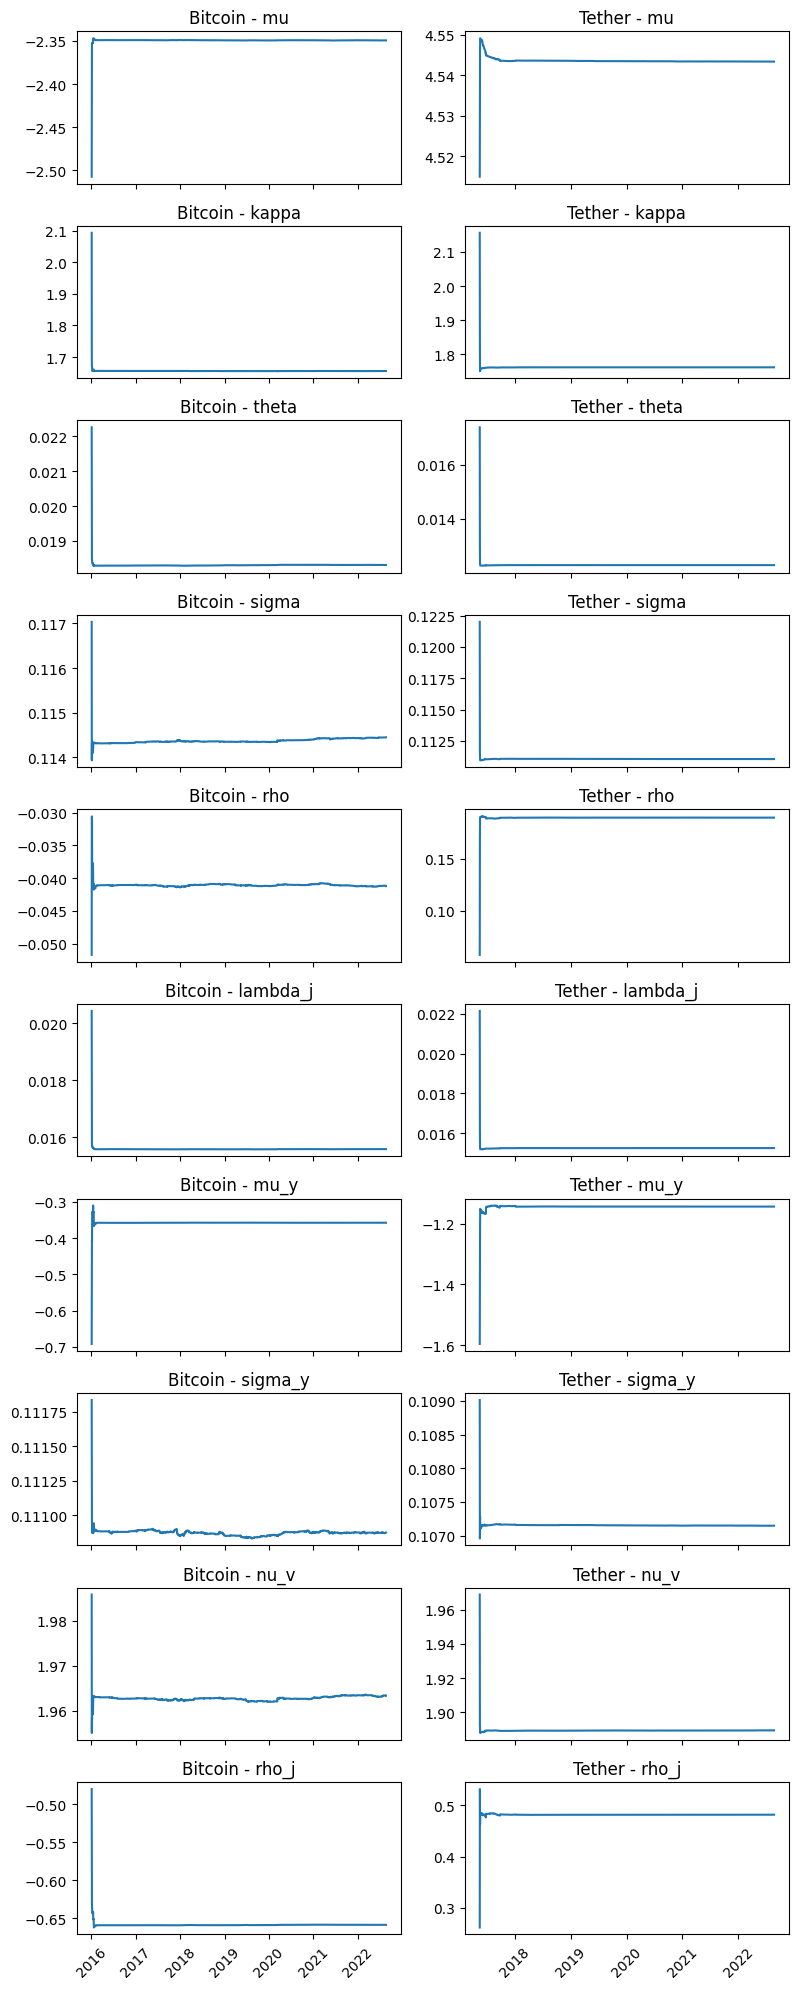

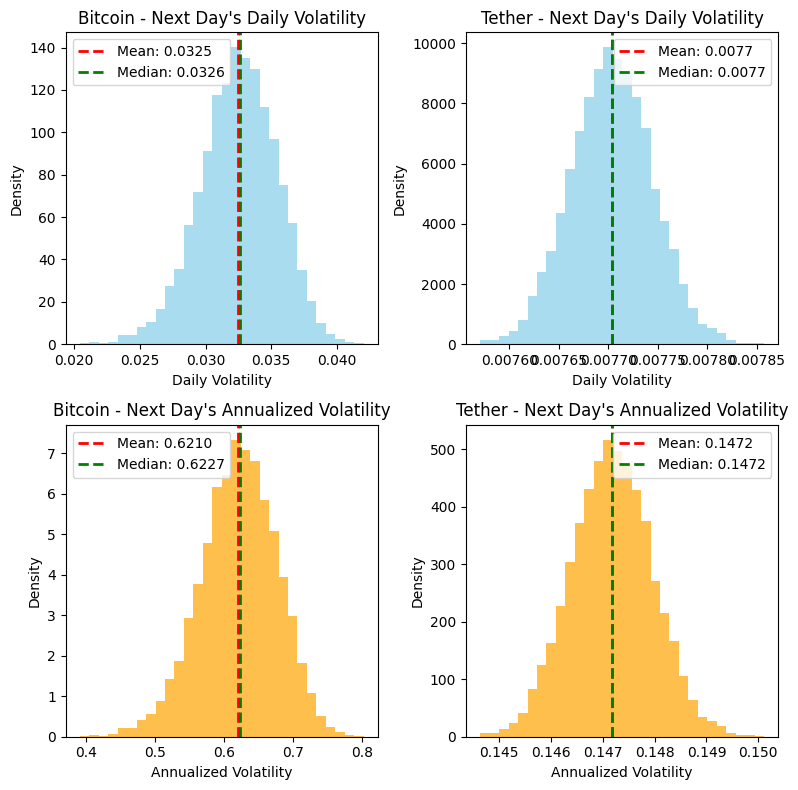

In [11]:
# Main Function
def main():
    """
    Main function to process multiple cryptocurrencies and visualize the results.
    """
    crypto_list = ['Bitcoin', 'Tether'] # Add more cryptocurrencies here
    all_results = []
    combined_parameters = []
    combined_vol_summaries = []

    for crypto_name in crypto_list:
        print(f"\nProcessing {crypto_name}...")
        results = process_coin(crypto_name)
        all_results.append(results)
        # Add to combined parameters DataFrame
        final_params = results['final_parameters']
        final_params['Cryptocurrency'] = crypto_name
        combined_parameters.append(final_params)
        # Add to combined volatility summaries
        vol_summary = results['vol_summary']
        vol_summary.insert(0, 'Cryptocurrency', crypto_name)
        combined_vol_summaries.append(vol_summary)

    # Create combined DataFrames
    combined_parameters_df = pd.DataFrame(combined_parameters)
    combined_vol_summary_df = pd.concat(combined_vol_summaries, ignore_index=True)

    # Print combined final parameter estimates
    print("\nCombined Final Parameter Estimates:")
    print(combined_parameters_df)

    # Print combined volatility summaries
    print("\nCombined Next Day's Volatility Summaries:")
    print(combined_vol_summary_df)

    # Plot parameter estimates over time for each coin
    num_params = len(all_results[0]['parameter_time_series'])
    num_coins = len(crypto_list)
    fig, axs = plt.subplots(num_params, num_coins, figsize=(4*num_coins, 2*num_params), sharex='col')

    # Ensure axs is a 2D array
    axs = np.atleast_2d(axs)

    for i, results in enumerate(all_results):
        parameter_time_series = results['parameter_time_series']
        dates = results['dates']
        for idx, key in enumerate(parameter_time_series):
            if num_params == 1 and num_coins == 1:
                ax = axs[0, 0]
            elif num_params == 1:
                ax = axs[0, i]
            elif num_coins == 1:
                ax = axs[idx, 0]
            else:
                ax = axs[idx, i]
            ax.plot(dates, parameter_time_series[key])
            ax.set_title(f'{results["crypto_name"]} - {key}')
            ax.tick_params(axis='x', labelrotation=45)
            # Format date axis
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
            ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    plt.tight_layout()
    plt.show()

    # Plot histograms for next day's volatilities
    fig, axs = plt.subplots(2, num_coins, figsize=(4*num_coins, 8))
    axs = np.atleast_2d(axs)
    for i, results in enumerate(all_results):
        # Daily volatility histogram
        if num_coins == 1:
            ax_daily = axs[0, 0]
            ax_annual = axs[1, 0]
        else:
            ax_daily = axs[0, i]
            ax_annual = axs[1, i]
        next_day_volatility = results['next_day_volatility']
        stats = results['vol_summary']
        mean = stats.loc[stats['Statistic'] == 'Mean', 'Daily Volatility'].values[0]
        median = stats.loc[stats['Statistic'] == 'Median', 'Daily Volatility'].values[0]
        ax_daily.hist(next_day_volatility, bins=30, density=True, alpha=0.7, color='skyblue')
        ax_daily.set_title(f'{results["crypto_name"]} - Next Day\'s Daily Volatility')
        ax_daily.set_xlabel('Daily Volatility')
        ax_daily.set_ylabel('Density')
        ax_daily.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f"Mean: {mean:.4f}")
        ax_daily.axvline(median, color='green', linestyle='dashed', linewidth=2, label=f"Median: {median:.4f}")
        ax_daily.legend()

        # Annualized volatility histogram
        next_day_annualized_volatility = results['next_day_annualized_volatility']
        mean = stats.loc[stats['Statistic'] == 'Mean', 'Annualized Volatility'].values[0]
        median = stats.loc[stats['Statistic'] == 'Median', 'Annualized Volatility'].values[0]
        ax_annual.hist(next_day_annualized_volatility, bins=30, density=True, alpha=0.7, color='orange')
        ax_annual.set_title(f'{results["crypto_name"]} - Next Day\'s Annualized Volatility')
        ax_annual.set_xlabel('Annualized Volatility')
        ax_annual.set_ylabel('Density')
        ax_annual.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f"Mean: {mean:.4f}")
        ax_annual.axvline(median, color='green', linestyle='dashed', linewidth=2, label=f"Median: {median:.4f}")
        ax_annual.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()